In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [2]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import random

import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from PIL import Image

from dataclasses import dataclass, field
from typing import Tuple, List

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from enum import Enum

class ModelType(Enum):
  BEST = "best"
  LAST = "last"

class DataType(Enum):
  TRAIN = "train"
  VAL = "val"
  TEST = "test"

base_dir = "/content/drive/MyDrive/DMS"


## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    case_name: str = "bi-lstm_attention_ensemble_24f/optuna/folds_adamw_prune" # 바꿔야하는 부분

    # 모델 구조
    lstm_num_layers: int = 3
    lstm_hidden_size: int = 512
    fc_hidden_size: int = 256
    dropout_rate: float = 0.2 # input-to-hidden (between layers)
    bidirectional: bool = True

    # 학습 설정
    batch_size: int = 32
    epochs: int = 100
    learning_rate: float = 3e-4
    optimizer: str = "adam" # or "sgd", "adamw"

    # 입력 데이터(수정한 부분)
    sequence_length: int = 24
    sliding_window_step: int = 24 # sliding window 사용 x -> seuqnce_length와 같은 값으로 설정
    features: list = field(default_factory=lambda: ["mar", "ear", "yaw", "pitch", "phone_detected"])
    labels: list = field(default_factory=lambda: ["normal", "phonecall", "text", "yawn"])

    apply_yaw_inversion: bool = False
    apply_noise_jittering: bool = False

    # 학습 제어 - 조기 종료 / 러닝레이트 스케줄러
    use_early_stopping: bool = False  # 조기 종료 사용 여부
    use_lr_scheduler: bool = False    # 학습률 스케줄러 사용 여부
    early_stopping_patience: int = 20 # early stopping 기준 epoch
    reduce_lr_factor: float = 0.5 # learning rate 감소 비율
    reduce_lr_patience: int = 7 # learning rate 감소 기준 epoch

    # 랜덤시드 설정
    random_seed: int = 24

    def __post_init__(self):
      self.results_save_path = f"{base_dir}/runs/{self.case_name}"
      self.model_save_path = f"{self.results_save_path}/weights"

      os.makedirs(self.results_save_path, exist_ok=True)
      os.makedirs(self.model_save_path, exist_ok=True)

      if self.sequence_length == 12:
        df_path = f'{base_dir}/data/splits/12frame_windows'
        self.group_col = 'groups_12'
      elif self.sequence_length == 24:
        df_path = f'{base_dir}/data/splits/24frame_windows'
        self.group_col = 'groups_24'

      self.train = pd.read_csv(os.path.join(df_path, "final_train.csv"))
      self.validation = pd.read_csv(os.path.join(df_path, "final_val.csv"))
      self.test = pd.read_csv(os.path.join(df_path, "final_test.csv"))

      # label_mapping
      self.label_encoding = {}
      self.label_decoding = {}
      for i, label in enumerate(self.labels):
          self.label_encoding[label] = i # 문자열 라벨 : 숫자 인덱스
          self.label_decoding[i] = label # 숫자 인덱스 : 문자열 라벨

      # 디바이스 설정
      self.use_cuda = torch.cuda.is_available()
      self.device = torch.device("cuda" if self.use_cuda else "cpu")

cfg = Config()
# print(cfg.case_name) # 사용 예시

In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

set_random_seed(cfg.random_seed)

### 데이터 로드

### train, val, test 데이터셋 로드

In [5]:
train_df = cfg.train.copy()
val_df = cfg.validation.copy()
test_df = cfg.test.copy()

In [6]:
# train normal undersampling
train_df = train_df[((train_df['label'] == 'normal') &
                    (train_df[cfg.group_col].isin([1, 2]))) | # sequence_length에 따라 group_col이 설정됨 -> 파일 로드 -> group_col로 정의된 groups_12 열 가져오기
                    (train_df['label'] != 'normal')]

### generate_sequence_dataset

In [7]:
def generate_sequence_dataset(
    df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, List[Tuple]]: # 가독성을 위해 변환 타입 명시. 작동x
    sequences, labels, metadata = [], [], []

    for (label, clip_id), clip_df in df.groupby(['label', 'clip_id']):
        clip_df = clip_df.sort_values('frame_no')
        frame_values = clip_df[cfg.features].values #(프레임 수, 변수 수)

        if len(frame_values) < cfg.sequence_length:
            continue

        for i in range(0, len(frame_values) - cfg.sequence_length + 1, cfg.sliding_window_step): # 전체 120, 슬라이딩 윈도우 12라면 (0, 109, 12)로 잘 들어간다
            seq = frame_values[i:i + cfg.sequence_length]
            if seq.shape[0] == cfg.sequence_length:
                sequences.append(seq)
                labels.append(cfg.label_encoding[label])
                # 학습 후 오분류 데이터 확인을 위한 시작 프레임 번호 저장
                metadata.append((label, clip_id, clip_df.iloc[i]['frame_no']))

    return TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)), metadata

### DataLoader

In [8]:
train_params = {
    "batch_size": cfg.batch_size,
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": cfg.use_cuda,
    "persistent_workers": cfg.use_cuda,
    "prefetch_factor": 2 if cfg.use_cuda else None,
}

test_params = {
    "batch_size": cfg.batch_size,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": cfg.use_cuda
}

In [9]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset, train_metadata = generate_sequence_dataset(train_df)
val_dataset, val_metadata = generate_sequence_dataset(val_df)
test_dataset, test_metadata = generate_sequence_dataset(test_df)

train_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)
test_loader = DataLoader(test_dataset, **test_params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in val_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


## 1-3. 모델 로드

### 모델 준비 함수

In [10]:
# 모델 준비
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: [B, T, H]
        score = torch.tanh(self.attn(lstm_output))         # [B, T, H]
        attn_weights = torch.softmax(self.context(score), dim=1)  # [B, T, 1]
        attended_output = torch.sum(attn_weights * lstm_output, dim=1)  # [B, H]
        return attended_output, attn_weights  # context vector, weights

In [11]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self, lstm_hidden_size, fc_hidden_size, dropout_rate):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = len(cfg.features)
        self.h_RNN_layers = cfg.lstm_num_layers
        self.h_RNN = lstm_hidden_size
        self.h_FC_dim = fc_hidden_size
        self.drop_p = dropout_rate
        self.num_classes = len(cfg.labels)
        self.bidirectional = cfg.bidirectional

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = self.h_RNN * (2 if self.bidirectional else 1)

        self.attention = Attention(lstm_output_dim) # Attention 추가
        self.fc1 = nn.Linear(lstm_output_dim, self.h_FC_dim)
        self.bn1 = nn.BatchNorm1d(self.h_FC_dim)  # Batch Normalization 추가
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        out, _ = self.LSTM(x_RNN)  # (batch, seq_len, hidden*2)

        attn_out, attn_weights = self.attention(out)  # attn_out: [B, H]

        # FC layers
        x = self.fc1(attn_out)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, attn_weights  # CrossEntropyLoss 사용 (Softmax 없음), attn_weights 함께 반환

### 모델 로드 함수

In [12]:
# 모델 로드 함수
def load_model(model, device, model_type=ModelType.BEST):
    """저장된 모델을 불러오는 함수"""
    model_path = os.path.join(cfg.model_save_path, f"{model_type.value}_model.pth")
    checkpoint = torch.load(model_path, map_location=device)
    #torch.save로 저장된 모델은 모델 가중치만 저장되어 있어 미리 모델 구조를 정의해줘야 한다
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_path}")
    return model

### 예측값 출력 함수

In [13]:
def get_preds_and_labels_ensemble(models: List[torch.nn.Module], device, data_loader, print_sample=False, max_print=10):
    """
    앙상블 모델을 이용한 예측 결과 및 입력/출력 정보 반환
    """
    for model in models:
        model.eval()

    all_inputs = []
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # 각 모델에 대해 softmax 확률 계산
            ensemble_probs = []
            for model in models:
                logits = model(x_batch)
                if isinstance(logits, tuple):
                    logits = logits[0]
                probs = F.softmax(logits, dim=1)
                ensemble_probs.append(probs)

            # 확률 평균
            avg_probs = torch.stack(ensemble_probs).mean(dim=0)
            preds = torch.argmax(avg_probs, dim=1)

            all_inputs.extend(x_batch.cpu())
            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(avg_probs.cpu().numpy())

    # 옵션: 일부 샘플 출력
    if print_sample:
        print("=== Sample Predictions ===")
        for i in range(min(max_print, len(all_labels))):
            print(f"[{i}] True: {all_labels[i]} | Pred: {all_preds[i]} | Prob: {all_probs[i]}")

    return (
        torch.stack(all_inputs),          # shape: [N, T, F]
        np.array(all_labels),             # shape: [N]
        np.array(all_preds),              # shape: [N]
        np.array(all_probs),              # shape: [N, num_classes]
    )


### 실행

In [14]:
import glob

def load_all_best_models(lstm_hidden_size, fc_hidden_size, dropout_rate, device) -> List[torch.nn.Module]:
    """폴더 내 모든 best_model_*.pth 파일을 불러와 모델 리스트 반환"""
    model_list = []
    pattern = os.path.join(cfg.model_save_path, "best_model_*.pth")
    model_paths = sorted(glob.glob(pattern))

    for path in model_paths:
        model = DecoderRNN(lstm_hidden_size, fc_hidden_size, dropout_rate).to(device)
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        model_list.append(model)
        print(f"✅ Loaded: {os.path.basename(path)}")

    return model_list

In [15]:
models = load_all_best_models(cfg.lstm_hidden_size, cfg.fc_hidden_size, cfg.dropout_rate, cfg.device) # best model load

✅ Loaded: best_model_0.pth
✅ Loaded: best_model_1.pth
✅ Loaded: best_model_2.pth
✅ Loaded: best_model_3.pth
✅ Loaded: best_model_4.pth


In [16]:
all_test_inputs, all_test_labels, all_test_preds, all_test_probs = get_preds_and_labels_ensemble(models, cfg.device, test_loader)

# 2. 해석 기법 도입

'''
목표 : 특성들을 사용해 어떻게 예측하는지 확인
1. 어텐션, shap, ig는 원래 개별 샘플에 적용하는 것인데 전체적인 경향성을 보기 위해 전체 데이터에 적용한 후 평균값을 이용한다. 더불어 std값도 병기
2. 어텐션에서 타임스탭별 평균값을 구하고 나머지는 특성별 평균값만 다룬다
3. 라벨별로 특성이 어떻게 적용되어서 예측되는지가 핵심이기에 라벨별로 계산 후 시각화한다
4. 테스트셋에 대하여 실제 라벨을 기준으로 한다
5. ig, shap는 계산이 느리므로 배치를 사용한다
'''

### 2-0. 필요한 함수들

### 2-4. IG

In [17]:
def integrated_gradients(input_tensor, model, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input_tensor).to(input_tensor.device)

    # 선형 보간을 위한 입력 준비
    interpolated = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(0, steps + 1)
    ]
    interpolated = torch.cat(interpolated, dim=0)  # shape: (steps+1, 24, 5)
    interpolated.requires_grad_(True)

    # 모델에 통과시켜 예측값 획득
    output = model(interpolated)  # shape: (steps+1, num_classes)
    if isinstance(output, tuple):
        output = output[0]

    # 가장 확신하는 클래스 선택
    pred_class = output[-1].argmax().item()
    target = output[:, pred_class].sum()

    # 기울기 계산
    target.backward()

    # 기울기 가져오기
    grads = interpolated.grad  # shape: (steps+1, 24, 5)

    # 평균 기울기 * (입력 - 기준) => IG
    avg_grads = grads.mean(dim=0)  # shape: (24, 5)
    ig = (input_tensor - baseline)[0] * avg_grads  # shape: (24, 5)

    return ig.detach()

In [18]:
# 결과 저장용 딕셔너리 (라벨별 리스트)
ig_by_label = defaultdict(list)

# IG 계산을 위한 준비
for model in models:
    model.to(cfg.device)
    # 모델 전체를 train으로 설정 (LSTM backward 가능)
    model.train()
    # BUT, BatchNorm은 오류 방지 위해 eval로 따로 설정
    for m in model.modules():
        if isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            m.eval()

### ig 실행 단계

In [20]:
# 전체 샘플에 대한 반복 * 5개 모델에 대해 반복 후 평균값 구하기
for i in range(len(all_test_inputs)):
    input_tensor = all_test_inputs[i].unsqueeze(0).to(cfg.device)  # (1, 24, 5)
    label = all_test_labels[i].item() if isinstance(all_test_labels[i], torch.Tensor) else all_test_labels[i]

    ig_stack = []  # 🔹 IG 저장 리스트를 샘플마다 새로 초기화

    for model in models:
        ig = integrated_gradients(input_tensor, model)
        ig_stack.append(ig.cpu().numpy())

    mean_ig = np.stack(ig_stack).mean(axis=0)  # shape: (24, 5)
    ig_by_label[label].append(mean_ig)


In [21]:
ig_by_label.keys() # 라벨을 key로 하여 샘플 수 X 타임스탭 수 X 특성 수

dict_keys([np.int64(0), np.int64(1), np.int64(2), np.int64(3)])

In [22]:
# 라벨별 평균 IG 계산
mean_ig_by_label = {}
std_ig_by_label = {}

for label, ig_list in ig_by_label.items():
    ig_array = np.stack(ig_list)                          # (샘플 수, 24, 5)
    mean_ig_by_label[label] = ig_array.mean(axis=0)       # (24, 5)
    std_ig_by_label[label] = ig_array.std(axis=0)         # (24, 5)

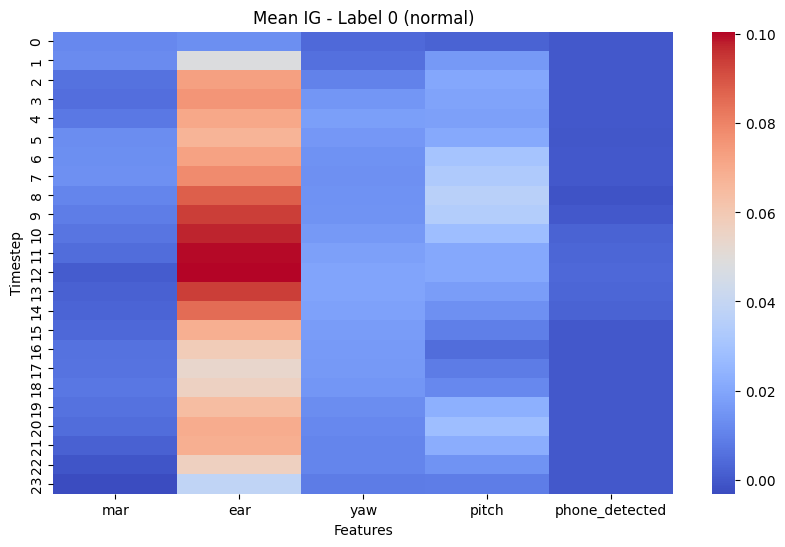

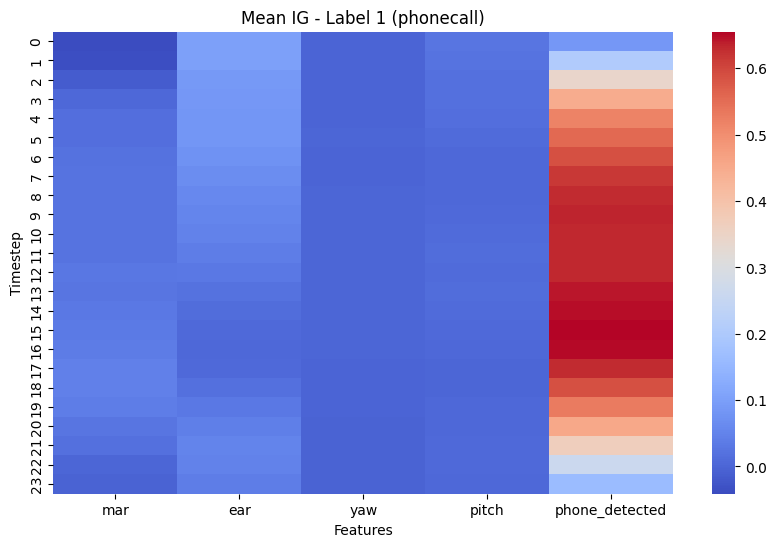

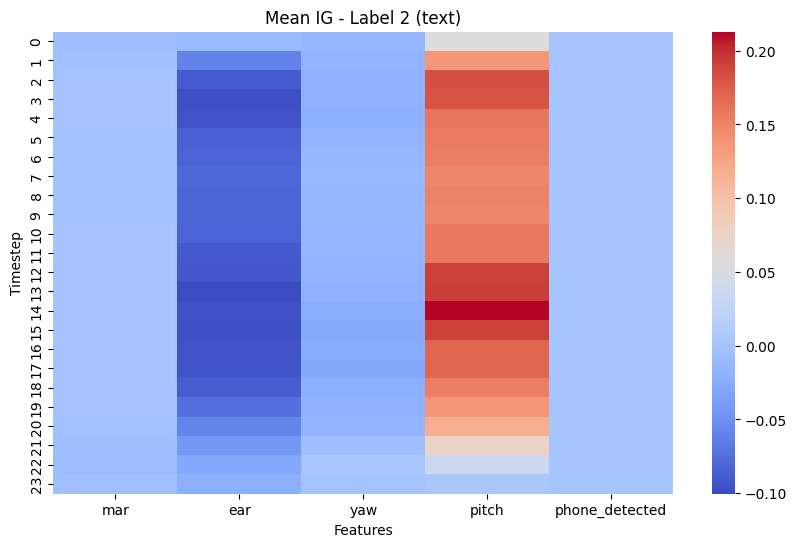

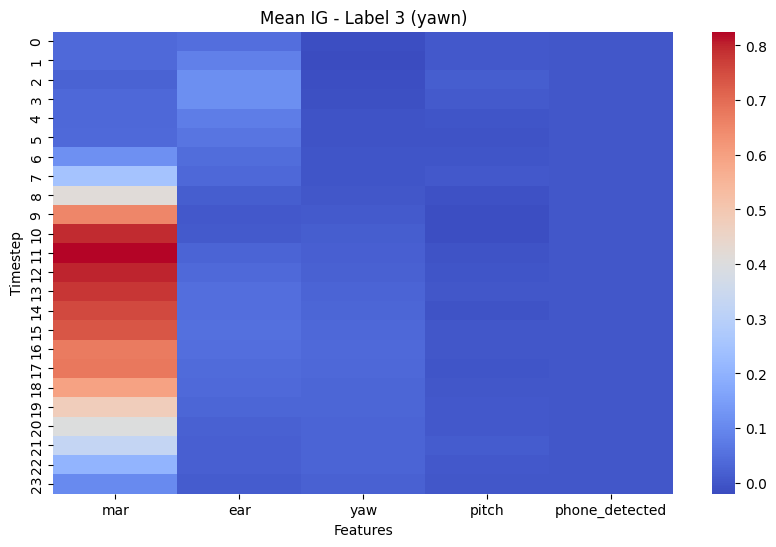

In [23]:
for label in sorted(mean_ig_by_label.keys()):
    plt.figure(figsize=(10, 6))
    sns.heatmap(mean_ig_by_label[label], cmap="coolwarm",
                xticklabels=cfg.features,
                yticklabels=range(24))

    label_name = cfg.labels[label]  # 정수 라벨을 문자열로 변환
    plt.title(f"Mean IG - Label {label} ({label_name})")
    plt.xlabel("Features")
    plt.ylabel("Timestep")
    plt.show()